# 1. Business Understanding


Previously, the brokerage office had first had to acquire the landlords as customers and then have their rental properties evaluated by an appraiser. Subsequently, an exposé was created with the personal expertise of the brokers regarding the Stuttgart rental situation. Finally, suitable customers had to be found for the rental property. Now Dehner Immobilien GmbH wants to expand, but not to open a new office with additional brokers in every city. So the process step of valuation and customer acquisition is to be digitized. Therefore, the valuation of real estate will now be done via artificial intelligence. Here, a prospective customer can conveniently have a real estate property appraised without the need for an appraiser or an agent to visit the property on site. The subsequent creation of the exposés for the Germany-wide properties will also be carried out centrally from the headquarters in Stuttgart based on the valuation results. The central question is: How can optimal rental prices be predicted by ML in the context of real estate valuation?

# 2. Data and Data Understanding

The data was taken from Immoscout24, the largest real estate platform in Germany. Immoscout24 lists both rental and purchase properties. However, the data on which this paper is based only contains listings for rental properties.  The dataset contains the most important properties. The dataset contains a total of 268,850 individual data, each with 49 variables. The 49 properties mapped here reflect the descriptive capabilities of Immobilienscout24. However, not all variables are suitable for use as predictors in multiple linear regression. Only data that have a direct correlation or impact on the rental price and can thus depict a pattern are suitable for this purpose. This excludes, for example, the type of heating or the internet connection strength. Therefore, the set of variables in the data preparation must be reduced to the properties relevant for the price prediction.

## 2.1 Import of Relevant Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
%matplotlib inline

## 2.2 Read Data

In [3]:
raw_data = pd.read_csv("https://storage.googleapis.com/ml-service-repository-datastorage/Digital_Valuation_of_Real_Estate_data.csv")
raw_data.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [8]:
def attribute_description(data):
    longestColumnName = len(max(np.array(data.columns), key=len))
    print("| Feature  | Data Type|")
    print("|-----|------|")
    for col in data.columns:
        description = ''
        col_dropna = data[col].dropna()
        example = col_dropna.sample(1).values[0]
        if type(example) == str:
            description = 'str '
            if len(col_dropna.unique()) < 10:
                description += '{'
                description += '; '.join([ f'"{name}"' for name in col_dropna.unique()])
                description += '}'
            else:
                description += '[ example: "'+ example + '" ]'
        elif (type(example) == np.int32) and (len(col_dropna.unique()) < 10) :
            description += 'dummy int32 {'
            description += '; '.join([ f'{name}' for name in sorted(col_dropna.unique())])
            description += '}'
        else:
            try:
                description = example.dtype
            except:
                 description = type(example)
        print("|" + col.ljust(longestColumnName)+ f'|   {description}  |')
 
attribute_description(raw_data)

## 2.3 Explore the Data

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

## 2.4 Explore Descriptive Statistics

In [4]:
raw_data.describe(include="all")

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
count,268850,261941.000000,223994,236231,45020.0,268850,268850,268850.000000,267018.000000,235492.000000,...,268850,268850,249103,215926,85518.000000,77787,80711.000000,46846.000000,46846.000000,268850
unique,16,NaN,13,3,NaN,2,2,NaN,NaN,NaN,...,419,8684,212621,189526,NaN,10,NaN,NaN,NaN,4
top,Nordrhein_Westfalen,NaN,central_heating,ONE_YEAR_FREE,NaN,False,True,NaN,NaN,NaN,...,Leipzig,Innenstadt,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat,NaN,C,NaN,NaN,NaN,Feb20
freq,62863,NaN,128977,227632,NaN,247679,165734,NaN,NaN,NaN,...,13723,4751,216,207,NaN,14613,NaN,NaN,NaN,79276
mean,NaN,151.206113,NaN,NaN,10.0,NaN,NaN,9.791958,3.389001,28.804928,...,NaN,NaN,NaN,NaN,76.990866,NaN,2013.904536,89.113612,0.199769,NaN
std,NaN,308.295790,NaN,NaN,0.0,NaN,NaN,6.408399,1.964874,16.337151,...,NaN,NaN,NaN,NaN,147.716278,NaN,10.963125,5.395805,0.009667,NaN
min,NaN,0.000000,NaN,NaN,10.0,NaN,NaN,0.000000,-12.330000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,1015.000000,71.430000,0.170500,NaN
25%,NaN,95.000000,NaN,NaN,10.0,NaN,NaN,6.000000,2.000000,10.000000,...,NaN,NaN,NaN,NaN,54.000000,NaN,2012.000000,90.760000,0.191500,NaN
50%,NaN,135.000000,NaN,NaN,10.0,NaN,NaN,9.000000,3.390000,40.000000,...,NaN,NaN,NaN,NaN,70.000000,NaN,2017.000000,90.760000,0.198500,NaN
75%,NaN,190.000000,NaN,NaN,10.0,NaN,NaN,13.000000,4.570000,40.000000,...,NaN,NaN,NaN,NaN,90.000000,NaN,2019.000000,90.760000,0.205500,NaN


In [5]:
raw_data.isnull().sum()

regio1                           0
serviceCharge                 6909
heatingType                  44856
telekomTvOffer               32619
telekomHybridUploadSpeed    223830
newlyConst                       0
balcony                          0
picturecount                     0
pricetrend                    1832
telekomUploadSpeed           33358
totalRent                    40517
yearConstructed              57045
scoutId                          0
noParkSpaces                175798
firingTypes                  56964
hasKitchen                       0
geo_bln                          0
cellar                           0
yearConstructedRange         57045
baseRent                         0
houseNumber                  71018
livingSpace                      0
geo_krs                          0
condition                    68489
interiorQual                112665
petsAllowed                 114573
street                           0
streetPlain                  71013
lift                

## 2.5 Data Cleaning
Elimination of Data which does not fit for a price prediction model

In [6]:
data1 = raw_data.drop(["heatingType",
                       "telekomTvOffer",
                       "telekomHybridUploadSpeed",
                       "picturecount",
                       "pricetrend",
                       "telekomUploadSpeed",
                       "scoutId",
                       "noParkSpaces",
                       "firingTypes",
                       "geo_bln",
                       "yearConstructedRange",
                       "houseNumber",
                       "condition",
                       "interiorQual",
                       "petsAllowed",
                       "street",
                       "streetPlain",
                       "baseRentRange",
                       "thermalChar",
                       "numberOfFloors",
                       "noRoomsRange",
                       "livingSpaceRange",
                       "description",
                       "facilities",
                       "heatingCosts",
                       "energyEfficiencyClass",
                       "lastRefurbish",
                       "electricityKwhPrice",
                       "electricityBasePrice",
                       "date"], axis=1)

In [7]:
data1.describe(include="all")

,regio1,serviceCharge,newlyConst,balcony,totalRent,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,geo_krs,lift,typeOfFlat,geo_plz,noRooms,floor,garden,regio2,regio3
count,268850,261941.000000,268850,268850,2.283330e+05,211805.000000,268850,268850,2.688500e+05,268850.000000,268850,268850,232236,268850.000000,268850.000000,217541.000000,268850,268850,268850
unique,16,NaN,2,2,NaN,NaN,2,2,NaN,NaN,419,2,10,NaN,NaN,NaN,2,419,8684
top,Nordrhein_Westfalen,NaN,False,True,NaN,NaN,False,True,NaN,NaN,Leipzig,False,apartment,NaN,NaN,NaN,False,Leipzig,Innenstadt
freq,62863,NaN,247679,165734,NaN,NaN,176794,172235,NaN,NaN,13723,205528,131522,NaN,NaN,NaN,216093,13723,4751
mean,NaN,151.206113,NaN,NaN,9.013315e+02,1966.400590,NaN,NaN,6.941294e+02,74.355548,NaN,NaN,NaN,37283.022235,2.641261,2.122405,NaN,NaN,NaN
std,NaN,308.295790,NaN,NaN,3.323833e+04,46.992207,NaN,NaN,1.953602e+04,254.759208,NaN,NaN,NaN,27798.037296,2.633440,3.634934,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000e+00,1000.000000,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,852.000000,1.000000,-1.000000,NaN,NaN,NaN
25%,NaN,95.000000,NaN,NaN,4.698000e+02,1950.000000,NaN,NaN,3.380000e+02,54.000000,NaN,NaN,NaN,9128.000000,2.000000,1.000000,NaN,NaN,NaN
50%,NaN,135.000000,NaN,NaN,6.500000e+02,1973.000000,NaN,NaN,4.900000e+02,67.320000,NaN,NaN,NaN,38667.000000,3.000000,2.000000,NaN,NaN,NaN
75%,NaN,190.000000,NaN,NaN,9.850000e+02,1996.000000,NaN,NaN,7.990000e+02,87.000000,NaN,NaN,NaN,57072.000000,3.000000,3.000000,NaN,NaN,NaN


In [8]:
data1.isnull().sum()

regio1                 0
serviceCharge       6909
newlyConst             0
balcony                0
totalRent          40517
yearConstructed    57045
hasKitchen             0
cellar                 0
baseRent               0
livingSpace            0
geo_krs                0
lift                   0
typeOfFlat         36614
geo_plz                0
noRooms                0
floor              51309
garden                 0
regio2                 0
regio3                 0
dtype: int64

Elimination of some more data which does not fit in this model

In [9]:
data2 = data1.drop(["typeOfFlat",
                    "totalRent",
                    "floor"], axis=1)

In [10]:
data2.describe(include="all")

,regio1,serviceCharge,newlyConst,balcony,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,geo_krs,lift,geo_plz,noRooms,garden,regio2,regio3
count,268850,261941.000000,268850,268850,211805.000000,268850,268850,2.688500e+05,268850.000000,268850,268850,268850.000000,268850.000000,268850,268850,268850
unique,16,NaN,2,2,NaN,2,2,NaN,NaN,419,2,NaN,NaN,2,419,8684
top,Nordrhein_Westfalen,NaN,False,True,NaN,False,True,NaN,NaN,Leipzig,False,NaN,NaN,False,Leipzig,Innenstadt
freq,62863,NaN,247679,165734,NaN,176794,172235,NaN,NaN,13723,205528,NaN,NaN,216093,13723,4751
mean,NaN,151.206113,NaN,NaN,1966.400590,NaN,NaN,6.941294e+02,74.355548,NaN,NaN,37283.022235,2.641261,NaN,NaN,NaN
std,NaN,308.295790,NaN,NaN,46.992207,NaN,NaN,1.953602e+04,254.759208,NaN,NaN,27798.037296,2.633440,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,1000.000000,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,852.000000,1.000000,NaN,NaN,NaN
25%,NaN,95.000000,NaN,NaN,1950.000000,NaN,NaN,3.380000e+02,54.000000,NaN,NaN,9128.000000,2.000000,NaN,NaN,NaN
50%,NaN,135.000000,NaN,NaN,1973.000000,NaN,NaN,4.900000e+02,67.320000,NaN,NaN,38667.000000,3.000000,NaN,NaN,NaN
75%,NaN,190.000000,NaN,NaN,1996.000000,NaN,NaN,7.990000e+02,87.000000,NaN,NaN,57072.000000,3.000000,NaN,NaN,NaN


In [11]:
data2.isnull().sum()

regio1                 0
serviceCharge       6909
newlyConst             0
balcony                0
yearConstructed    57045
hasKitchen             0
cellar                 0
baseRent               0
livingSpace            0
geo_krs                0
lift                   0
geo_plz                0
noRooms                0
garden                 0
regio2                 0
regio3                 0
dtype: int64

Elimination of location data; zip code left!

In [12]:
data3 = data2.drop(["regio1",
                    "geo_krs",
                    "regio2",
                    "regio3"], axis=1)

In [13]:
data3.describe(include="all")

,serviceCharge,newlyConst,balcony,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,lift,geo_plz,noRooms,garden
count,261941.000000,268850,268850,211805.000000,268850,268850,2.688500e+05,268850.000000,268850,268850.000000,268850.000000,268850
unique,NaN,2,2,NaN,2,2,NaN,NaN,2,NaN,NaN,2
top,NaN,False,True,NaN,False,True,NaN,NaN,False,NaN,NaN,False
freq,NaN,247679,165734,NaN,176794,172235,NaN,NaN,205528,NaN,NaN,216093
mean,151.206113,NaN,NaN,1966.400590,NaN,NaN,6.941294e+02,74.355548,NaN,37283.022235,2.641261,NaN
std,308.295790,NaN,NaN,46.992207,NaN,NaN,1.953602e+04,254.759208,NaN,27798.037296,2.633440,NaN
min,0.000000,NaN,NaN,1000.000000,NaN,NaN,0.000000e+00,0.000000,NaN,852.000000,1.000000,NaN
25%,95.000000,NaN,NaN,1950.000000,NaN,NaN,3.380000e+02,54.000000,NaN,9128.000000,2.000000,NaN
50%,135.000000,NaN,NaN,1973.000000,NaN,NaN,4.900000e+02,67.320000,NaN,38667.000000,3.000000,NaN
75%,190.000000,NaN,NaN,1996.000000,NaN,NaN,7.990000e+02,87.000000,NaN,57072.000000,3.000000,NaN


In [14]:
data3.isnull().sum()

serviceCharge       6909
newlyConst             0
balcony                0
yearConstructed    57045
hasKitchen             0
cellar                 0
baseRent               0
livingSpace            0
lift                   0
geo_plz                0
noRooms                0
garden                 0
dtype: int64

## Missing Values

Elimination of Null-Values

In [15]:
data_no_mv = data3.dropna(axis=0)

In [16]:
data_no_mv.describe(include="all")

,serviceCharge,newlyConst,balcony,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,lift,geo_plz,noRooms,garden
count,208195.000000,208195,208195,208195.000000,208195,208195,208195.00000,208195.000000,208195,208195.000000,208195.000000,208195
unique,NaN,2,2,NaN,2,2,NaN,NaN,2,NaN,NaN,2
top,NaN,False,True,NaN,False,True,NaN,NaN,False,NaN,NaN,False
freq,NaN,187880,134169,NaN,139914,137208,NaN,NaN,154725,NaN,NaN,169100
mean,152.703730,NaN,NaN,1966.208526,NaN,NaN,653.92228,74.172720,NaN,36991.365917,2.650684,NaN
std,343.201422,NaN,NaN,46.979715,NaN,NaN,582.88770,155.398388,NaN,27655.475222,2.516210,NaN
min,0.000000,NaN,NaN,1000.000000,NaN,NaN,0.00000,0.000000,NaN,1057.000000,1.000000,NaN
25%,95.000000,NaN,NaN,1950.000000,NaN,NaN,335.00000,54.850000,NaN,9130.000000,2.000000,NaN
50%,136.000000,NaN,NaN,1972.000000,NaN,NaN,490.00000,67.350000,NaN,38368.000000,3.000000,NaN
75%,190.000000,NaN,NaN,1996.000000,NaN,NaN,800.00000,86.510000,NaN,56068.000000,3.000000,NaN


In [17]:
data_no_mv.isnull().sum()

serviceCharge      0
newlyConst         0
balcony            0
yearConstructed    0
hasKitchen         0
cellar             0
baseRent           0
livingSpace        0
lift               0
geo_plz            0
noRooms            0
garden             0
dtype: int64

## Double Values

Elimination of values which occur twice in the data set

In [18]:
data_no_mv[data_no_mv.duplicated(keep=False)]

,serviceCharge,newlyConst,balcony,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,lift,geo_plz,noRooms,garden
17,50.00,False,False,1897.0,False,False,200.00,50.00,False,4720,2.0,True
19,290.00,False,True,2013.0,False,True,1343.48,127.95,True,37073,5.0,False
50,50.00,False,True,1980.0,False,True,285.00,36.29,True,15517,1.0,False
52,170.00,False,False,1905.0,False,True,365.00,79.00,False,9337,3.0,False
57,113.80,False,False,1969.0,False,True,340.00,42.52,False,19057,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
268801,68.00,False,True,1999.0,False,True,190.00,28.54,False,17098,1.0,False
268815,79.20,False,True,1984.0,False,True,329.87,65.45,False,6124,4.0,False
268821,80.00,True,True,2019.0,False,True,680.00,79.50,False,56281,2.0,False
268826,59.54,False,True,1978.0,False,False,309.61,59.54,False,4746,3.0,False


In [19]:
data_no_dv = data_no_mv.drop_duplicates(keep="first")

In [20]:
data_no_dv[data_no_dv.duplicated(keep=False)]

,serviceCharge,newlyConst,balcony,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,lift,geo_plz,noRooms,garden


## Distribution

In [21]:
data_no_dv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198749 entries, 0 to 268849
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   serviceCharge    198749 non-null  float64
 1   newlyConst       198749 non-null  bool   
 2   balcony          198749 non-null  bool   
 3   yearConstructed  198749 non-null  float64
 4   hasKitchen       198749 non-null  bool   
 5   cellar           198749 non-null  bool   
 6   baseRent         198749 non-null  float64
 7   livingSpace      198749 non-null  float64
 8   lift             198749 non-null  bool   
 9   geo_plz          198749 non-null  int64  
 10  noRooms          198749 non-null  float64
 11  garden           198749 non-null  bool   
dtypes: bool(6), float64(5), int64(1)
memory usage: 11.8 MB


In [22]:
data_no_dv.describe(include="all")

,serviceCharge,newlyConst,balcony,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,lift,geo_plz,noRooms,garden
count,198749.000000,198749,198749,198749.000000,198749,198749,198749.000000,198749.000000,198749,198749.000000,198749.000000,198749
unique,NaN,2,2,NaN,2,2,NaN,NaN,2,NaN,NaN,2
top,NaN,False,True,NaN,False,True,NaN,NaN,False,NaN,NaN,False
freq,NaN,179561,127983,NaN,132463,131153,NaN,NaN,147937,NaN,NaN,161044
mean,153.694116,NaN,NaN,1966.017343,NaN,NaN,658.968301,74.517406,NaN,37554.190391,2.654986,NaN
std,350.688667,NaN,NaN,47.346554,NaN,NaN,586.128842,158.910643,NaN,27623.931360,2.567069,NaN
min,0.000000,NaN,NaN,1000.000000,NaN,NaN,0.000000,0.000000,NaN,1057.000000,1.000000,NaN
25%,97.000000,NaN,NaN,1950.000000,NaN,NaN,340.000000,55.000000,NaN,9328.000000,2.000000,NaN
50%,138.110000,NaN,NaN,1972.000000,NaN,NaN,495.000000,68.000000,NaN,39104.000000,3.000000,NaN
75%,190.000000,NaN,NaN,1996.000000,NaN,NaN,810.000000,87.000000,NaN,56566.000000,3.000000,NaN


Examination of the distribtion of the remaining variables

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='serviceCharge', ylabel='Density'>

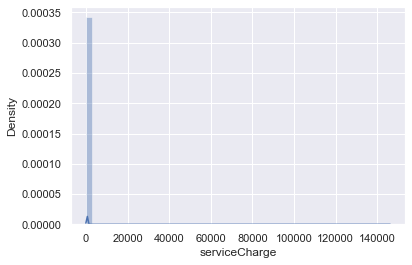

In [24]:
sns.distplot(data_no_dv["serviceCharge"])

## get rid of the Outliers

In [28]:
q = data_no_dv["serviceCharge"].quantile(0.99)
q

450.0

In [29]:
data_1 = data_no_dv[data_no_dv["serviceCharge"]<q]

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='serviceCharge', ylabel='Density'>

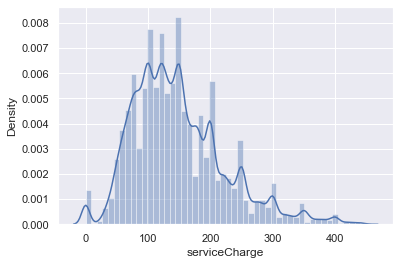

In [30]:
sns.distplot(data_1["serviceCharge"])

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='baseRent', ylabel='Density'>

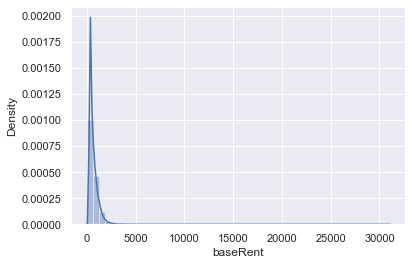

In [31]:
sns.distplot(data_1["baseRent"])

In [32]:
q_1 = data_1["baseRent"].quantile(0.99)
q_1

2220.0

In [33]:
data_2 = data_1[data_1["baseRent"]<q_1]

In [34]:
q_2 = data_no_mv["baseRent"].quantile(0.01)
q_2

170.0

In [35]:
data_3 = data_2[data_2["baseRent"]>q_2]

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='baseRent', ylabel='Density'>

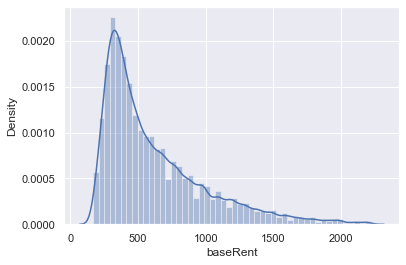

In [36]:
sns.distplot(data_3["baseRent"])

## Wrong Values

Clean the data from incorrect values

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='livingSpace', ylabel='Density'>

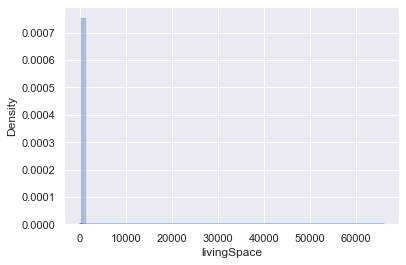

In [37]:
sns.distplot(data_3["livingSpace"])

In [38]:
q_3 = data_3["livingSpace"].quantile(0.995)
q_3

175.0

In [39]:
data_4 = data_3[data_3["livingSpace"]<q_3]

In [40]:
q_4 = data_4["livingSpace"].quantile(0.005)
q_4

20.0

In [41]:
data_5 = data_4[data_4["livingSpace"]>q_4]

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='livingSpace', ylabel='Density'>

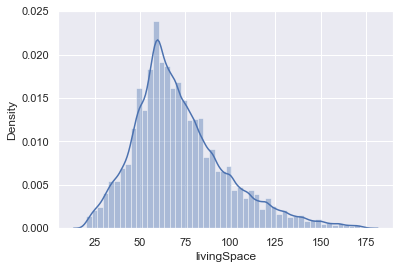

In [42]:
sns.distplot(data_5["livingSpace"])

In [43]:
data_5["geo_plz"].min()

1057

In [44]:
data_5["geo_plz"].max()

99994

In [45]:
data_5 = data_5[data_5["geo_plz"]>1066] #Dresden hat die niedrigste PLZ mit 01067

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='noRooms', ylabel='Density'>

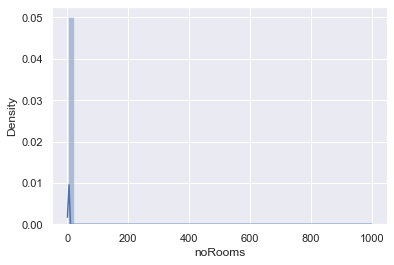

In [46]:
sns.distplot(data_5["noRooms"])

In [47]:
q_5 = data_5["noRooms"].quantile(0.995)
q_5

5.0

In [48]:
data_6 = data_5[data_5["noRooms"]<q_5]

In [49]:
q_6 = data_6["noRooms"].quantile(0.005)
q_6

1.0

In [50]:
data_7 = data_6[data_6["noRooms"]>q_6]

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='noRooms', ylabel='Density'>

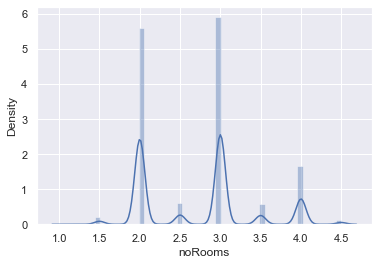

In [51]:
sns.distplot(data_7["noRooms"])

## Final Preperation

Check the remaining variables for the distribution of the data

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='yearConstructed', ylabel='Density'>

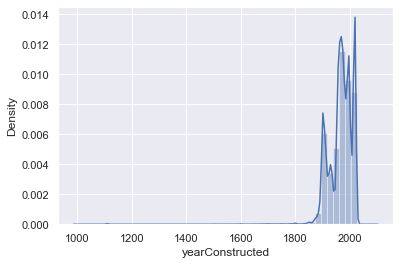

In [52]:
sns.distplot(data_7["yearConstructed"])

In [53]:
data_8 = data_7[data_7["yearConstructed"]<2021.0]

In [54]:
q_7 = data_8["yearConstructed"].quantile(0.005)
q_7

1823.0

In [55]:
data_9 = data_8[data_8["yearConstructed"]>q_7]

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='yearConstructed', ylabel='Density'>

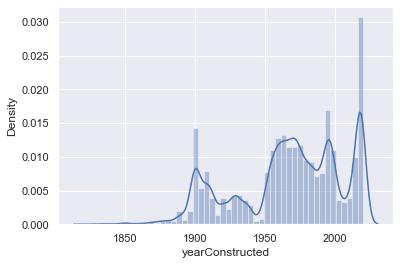

In [56]:
sns.distplot(data_9["yearConstructed"])

In [57]:
data_9.describe(include="all")

,serviceCharge,newlyConst,balcony,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,lift,geo_plz,noRooms,garden
count,169772.000000,169772,169772,169772.000000,169772,169772,169772.000000,169772.000000,169772,169772.000000,169772.000000,169772
unique,NaN,2,2,NaN,2,2,NaN,NaN,2,NaN,NaN,2
top,NaN,False,True,NaN,False,True,NaN,NaN,False,NaN,NaN,False
freq,NaN,152899,111973,NaN,117171,115113,NaN,NaN,128697,NaN,NaN,137553
mean,150.577057,NaN,NaN,1967.520816,NaN,NaN,627.400543,74.150277,NaN,37258.531772,2.722473,NaN
std,69.131265,NaN,NaN,38.220866,NaN,NaN,369.127139,23.007341,NaN,27225.560201,0.697763,NaN
min,0.000000,NaN,NaN,1824.000000,NaN,NaN,170.460000,20.320000,NaN,1067.000000,1.100000,NaN
25%,100.000000,NaN,NaN,1950.000000,NaN,NaN,350.000000,58.000000,NaN,9235.000000,2.000000,NaN
50%,140.000000,NaN,NaN,1972.000000,NaN,NaN,500.000000,69.265000,NaN,39104.000000,3.000000,NaN
75%,190.000000,NaN,NaN,1996.000000,NaN,NaN,800.000000,86.000000,NaN,55152.750000,3.000000,NaN


### convert the boolean data into integer values

In [58]:
data_9['newlyConst'] = data_9['newlyConst']*1
data_9['balcony'] = data_9['balcony']*1
data_9['hasKitchen'] = data_9['hasKitchen']*1
data_9['cellar'] = data_9['cellar']*1
data_9['lift'] = data_9['lift']*1
data_9['garden'] = data_9['garden']*1

<ipython-input-58-8fd0b50daa89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_9['newlyConst'] = data_9['newlyConst']*1
<ipython-input-58-8fd0b50daa89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_9['balcony'] = data_9['balcony']*1
<ipython-input-58-8fd0b50daa89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [59]:
data_9.head()

,serviceCharge,newlyConst,balcony,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,lift,geo_plz,noRooms,garden
0,245.00,0,0,1965.0,0,1,595.0,86.00,0,44269,4.0,1
1,134.00,0,1,1871.0,0,0,800.0,89.00,0,67459,3.0,0
2,255.00,1,1,2019.0,0,1,965.0,83.80,1,1097,3.0,0
3,58.15,0,1,1964.0,0,0,343.0,58.15,0,9599,3.0,0
4,138.00,0,1,1950.0,0,0,765.0,84.97,0,28213,3.0,0


In [60]:
data_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169772 entries, 0 to 268849
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   serviceCharge    169772 non-null  float64
 1   newlyConst       169772 non-null  int64  
 2   balcony          169772 non-null  int64  
 3   yearConstructed  169772 non-null  float64
 4   hasKitchen       169772 non-null  int64  
 5   cellar           169772 non-null  int64  
 6   baseRent         169772 non-null  float64
 7   livingSpace      169772 non-null  float64
 8   lift             169772 non-null  int64  
 9   geo_plz          169772 non-null  int64  
 10  noRooms          169772 non-null  float64
 11  garden           169772 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 16.8 MB


# 3. Data Preparation

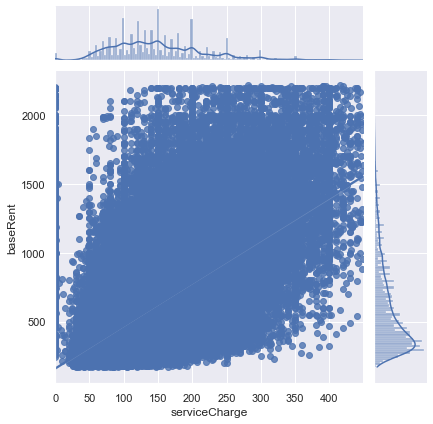

In [61]:
sns.jointplot(x='serviceCharge',y='baseRent', kind='reg', data=data_9)
# correlation detected --> keep service Charge

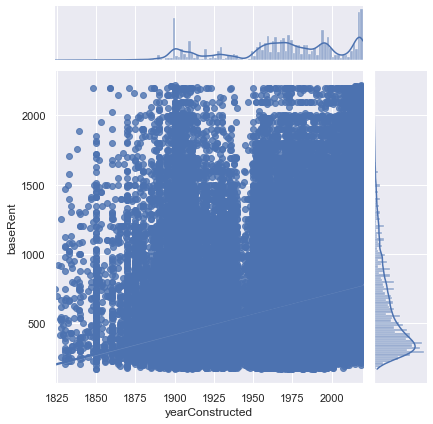

In [62]:
sns.jointplot(x='yearConstructed',y='baseRent', kind='reg', data=data_9)
#correlation detected --> keep year Constructed

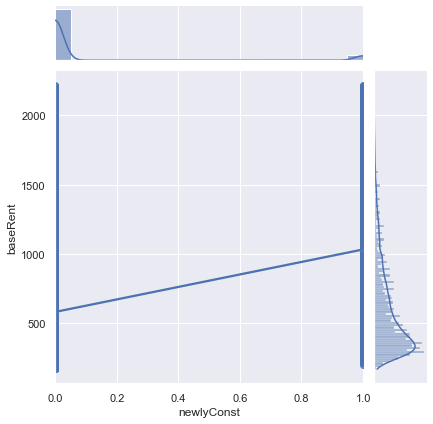

In [63]:
sns.jointplot(x='newlyConst',y='baseRent', kind='reg', data=data_9)
# correlation detected --> keep newly Const

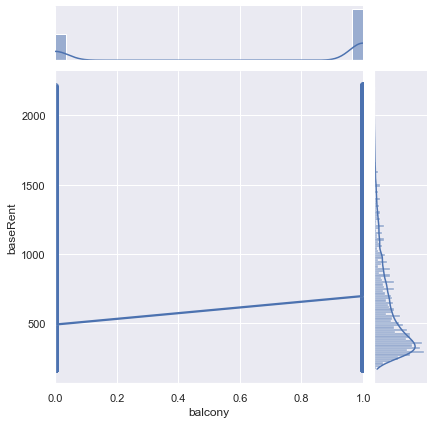

In [64]:
sns.jointplot(x='balcony',y='baseRent', kind='reg', data=data_9)
# no significant correlation --> drop balcony

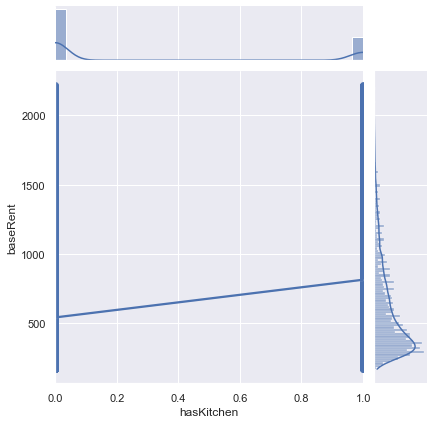

In [65]:
sns.jointplot(x='hasKitchen',y='baseRent', kind='reg', data=data_9)
# correlation detected --> keep hasKitchen

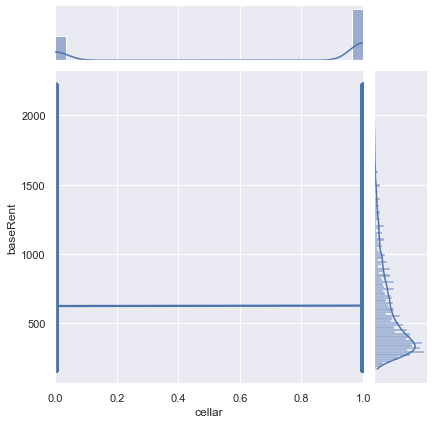

In [66]:
sns.jointplot(x='cellar',y='baseRent', kind='reg', data=data_9)
# no correlation --> drop cellar

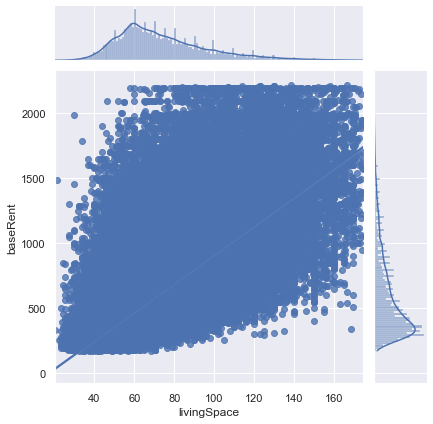

In [67]:
sns.jointplot(x='livingSpace',y='baseRent', kind='reg', data=data_9)
# correlation detected --> keep livingSpace

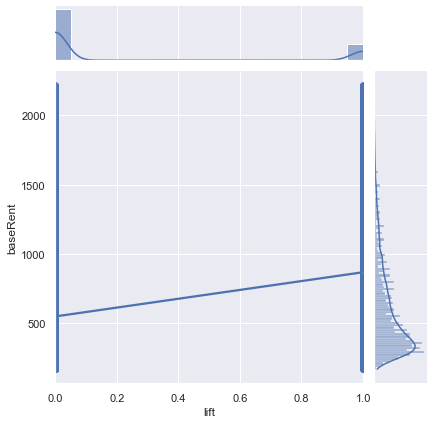

In [68]:
sns.jointplot(x='lift',y='baseRent', kind='reg', data=data_9)
# correlation detected --> keep lift

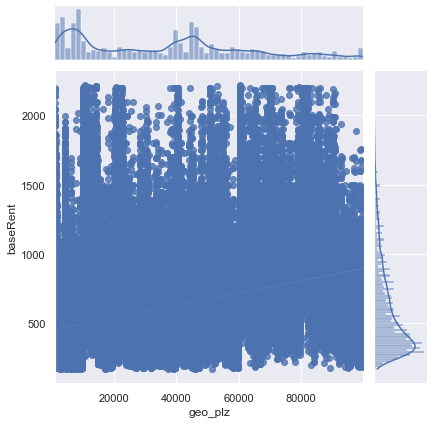

In [69]:
sns.jointplot(x='geo_plz',y='baseRent', kind='reg', data=data_9)
# correlation detected --> keep geo_plz

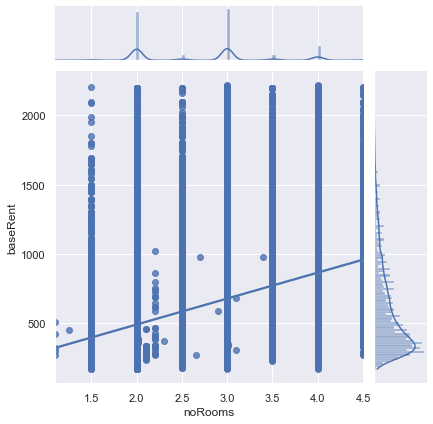

In [70]:
sns.jointplot(x='noRooms',y='baseRent', kind='reg', data=data_9)
# correlation detected --> keep noRooms

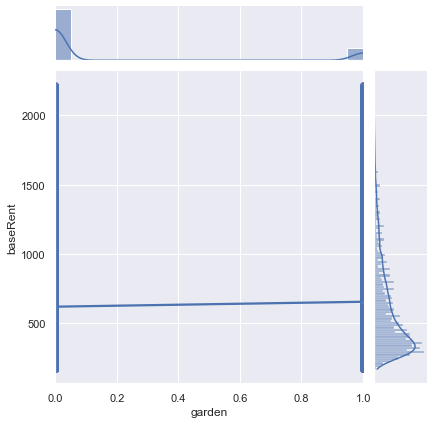

In [71]:
sns.jointplot(x='garden',y='baseRent', kind='reg', data=data_9)
# no correlation --> drop garden!

Eliminate those variables that do not have a significant effect on the target variable.

In [72]:
data_cleaned = data_9.drop(["balcony",
                    "cellar",
                    "garden"], axis=1)

In [73]:
data_cleaned.describe(include='all')

,serviceCharge,newlyConst,yearConstructed,hasKitchen,baseRent,livingSpace,lift,geo_plz,noRooms
count,169772.000000,169772.000000,169772.000000,169772.000000,169772.000000,169772.000000,169772.000000,169772.000000,169772.000000
mean,150.577057,0.099386,1967.520816,0.309833,627.400543,74.150277,0.241942,37258.531772,2.722473
std,69.131265,0.299181,38.220866,0.462426,369.127139,23.007341,0.428261,27225.560201,0.697763
min,0.000000,0.000000,1824.000000,0.000000,170.460000,20.320000,0.000000,1067.000000,1.100000
25%,100.000000,0.000000,1950.000000,0.000000,350.000000,58.000000,0.000000,9235.000000,2.000000
50%,140.000000,0.000000,1972.000000,0.000000,500.000000,69.265000,0.000000,39104.000000,3.000000
75%,190.000000,0.000000,1996.000000,1.000000,800.000000,86.000000,0.000000,55152.750000,3.000000
max,449.000000,1.000000,2020.000000,1.000000,2218.000000,174.800000,1.000000,99994.000000,4.500000


## 3.1 OLS Assumptions

from the upper jointplots it can already be deduced that linearity is not guaranteed for all data.

therefore the target variable is transformed via the logarithm to create linearity of the data.

In [74]:
log_price = np.log(data_cleaned["baseRent"])
data_cleaned["log_price"] = log_price
data_cleaned

,serviceCharge,newlyConst,yearConstructed,hasKitchen,baseRent,livingSpace,lift,geo_plz,noRooms,log_price
0,245.00,0,1965.0,0,595.0,86.00,0,44269,4.0,6.388561
1,134.00,0,1871.0,0,800.0,89.00,0,67459,3.0,6.684612
2,255.00,1,2019.0,0,965.0,83.80,1,1097,3.0,6.872128
3,58.15,0,1964.0,0,343.0,58.15,0,9599,3.0,5.837730
4,138.00,0,1950.0,0,765.0,84.97,0,28213,3.0,6.639876
...,...,...,...,...,...,...,...,...,...,...
268845,90.00,0,2016.0,0,820.0,90.00,0,82390,3.0,6.709304
268846,220.00,0,1983.0,1,930.0,115.00,0,68519,3.5,6.835185
268847,220.00,0,1965.0,0,650.0,95.00,0,65552,4.0,6.476972
268848,175.00,1,2019.0,0,840.0,70.00,1,51069,2.0,6.733402


### Checking the effectiveness of the log transformation

Text(0.5, 1.0, 'log_price')

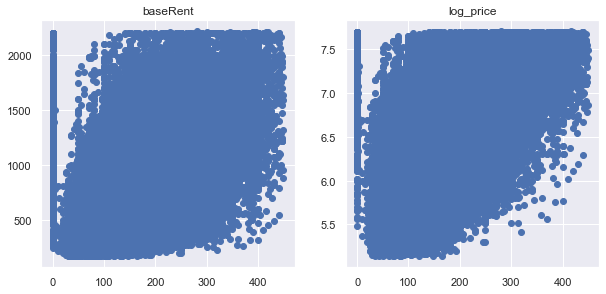

In [75]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.scatter(data_cleaned["serviceCharge"], data_cleaned["baseRent"])
plt.title("baseRent")

plt.subplot(222)
plt.scatter(data_cleaned["serviceCharge"], data_cleaned["log_price"])
plt.title("log_price")

Text(0.5, 1.0, 'log_price')

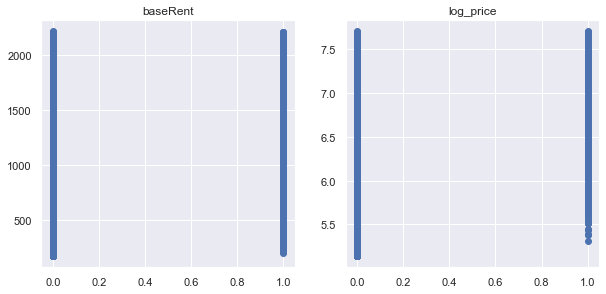

In [76]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.scatter(data_cleaned["newlyConst"], data_cleaned["baseRent"])
plt.title("baseRent")

plt.subplot(222)
plt.scatter(data_cleaned["newlyConst"], data_cleaned["log_price"])
plt.title("log_price")

Text(0.5, 1.0, 'log_price')

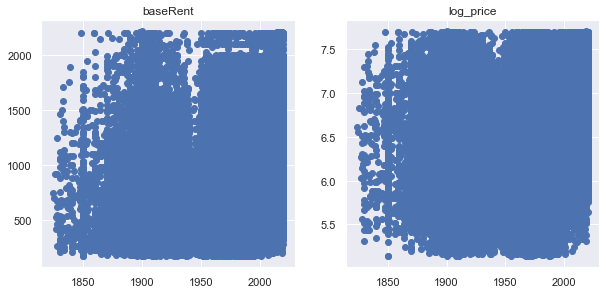

In [77]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plt.scatter(data_cleaned["yearConstructed"], data_cleaned["baseRent"])
plt.title("baseRent")

plt.subplot(222)
plt.scatter(data_cleaned["yearConstructed"], data_cleaned["log_price"])
plt.title("log_price")

Text(0.5, 1.0, 'log_price')

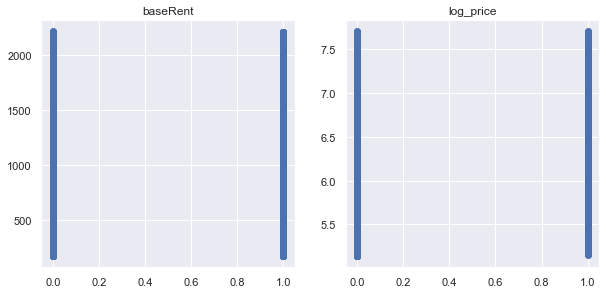

In [78]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plt.scatter(data_cleaned["hasKitchen"], data_cleaned["baseRent"])
plt.title("baseRent")

plt.subplot(222)
plt.scatter(data_cleaned["hasKitchen"], data_cleaned["log_price"])
plt.title("log_price")

Text(0.5, 1.0, 'log_price')

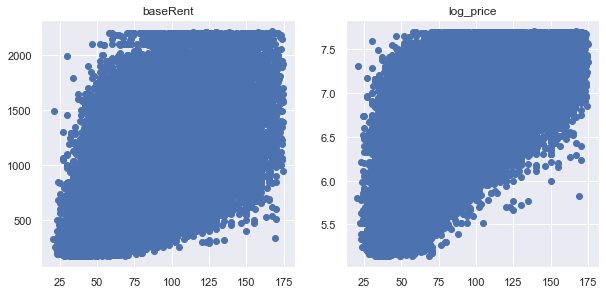

In [79]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plt.scatter(data_cleaned["livingSpace"], data_cleaned["baseRent"])
plt.title("baseRent")

plt.subplot(222)
plt.scatter(data_cleaned["livingSpace"], data_cleaned["log_price"])
plt.title("log_price")

Text(0.5, 1.0, 'log_price')

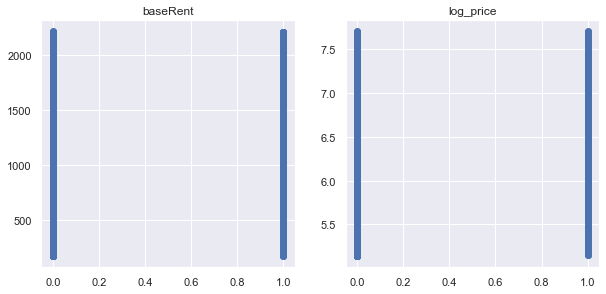

In [80]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plt.scatter(data_cleaned["lift"], data_cleaned["baseRent"])
plt.title("baseRent")

plt.subplot(222)
plt.scatter(data_cleaned["lift"], data_cleaned["log_price"])
plt.title("log_price")

Text(0.5, 1.0, 'log_price')

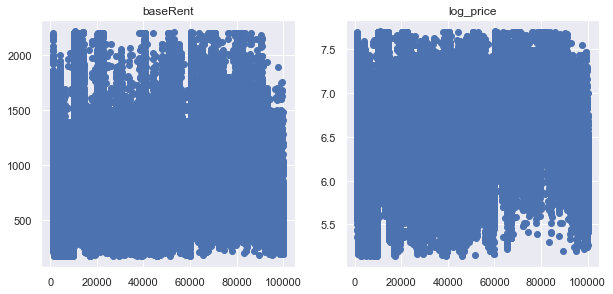

In [81]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plt.scatter(data_cleaned["geo_plz"], data_cleaned["baseRent"])
plt.title("baseRent")

plt.subplot(222)
plt.scatter(data_cleaned["geo_plz"], data_cleaned["log_price"])
plt.title("log_price")

Text(0.5, 1.0, 'log_price')

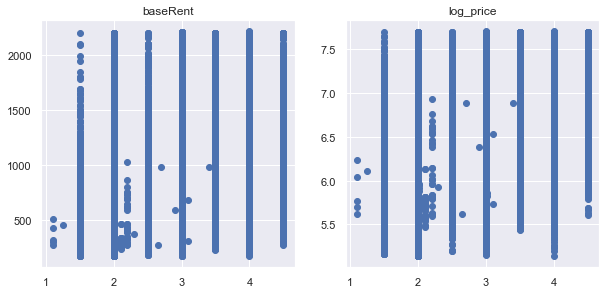

In [82]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plt.scatter(data_cleaned["noRooms"], data_cleaned["baseRent"])
plt.title("baseRent")

plt.subplot(222)
plt.scatter(data_cleaned["noRooms"], data_cleaned["log_price"])
plt.title("log_price")

In [83]:
data_lin = data_cleaned.drop(["baseRent"], axis=1)

## 3.2 Assumption No Multicollinearity

In [84]:
data_lin.columns.values

array(['serviceCharge', 'newlyConst', 'yearConstructed', 'hasKitchen',
       'livingSpace', 'lift', 'geo_plz', 'noRooms', 'log_price'],
      dtype=object)

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_lin.drop(["log_price"], axis = 1)
vif = pd.DataFrame()
vif["VIF"]= [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,10.349237,serviceCharge
1,1.310333,newlyConst
2,18.502446,yearConstructed
3,1.551697,hasKitchen
4,30.402962,livingSpace
5,1.676574,lift
6,3.080676,geo_plz
7,30.696412,noRooms


In [86]:
data_nomulti = data_lin.drop(["serviceCharge",
                                  "yearConstructed",
                                  "noRooms"], axis=1)

In [87]:
variables_2 = data_nomulti.drop(["log_price"], axis = 1)
vif = pd.DataFrame()
vif["VIF"]= [variance_inflation_factor(variables_2.values, i) for i in range(variables_2.shape[1])]
vif["Features"] = variables_2.columns
vif

,VIF,Features
0,1.295990,newlyConst
1,1.513116,hasKitchen
2,3.418712,livingSpace
3,1.560634,lift
4,2.920054,geo_plz


In [88]:
data_nomulti.head()

,newlyConst,hasKitchen,livingSpace,lift,geo_plz,log_price
0,0,0,86.00,0,44269,6.388561
1,0,0,89.00,0,67459,6.684612
2,1,0,83.80,1,1097,6.872128
3,0,0,58.15,0,9599,5.837730
4,0,0,84.97,0,28213,6.639876


## 3.3 New Indexation

In [89]:
data_final = data_nomulti.reset_index(drop=True)
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169772 entries, 0 to 169771
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   newlyConst   169772 non-null  int64  
 1   hasKitchen   169772 non-null  int64  
 2   livingSpace  169772 non-null  float64
 3   lift         169772 non-null  int64  
 4   geo_plz      169772 non-null  int64  
 5   log_price    169772 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 7.8 MB


In [11]:
data_final.describe()

NameError: name 'data_final' is not defined

## 3.4 Interrelationships of the final variables for modeling

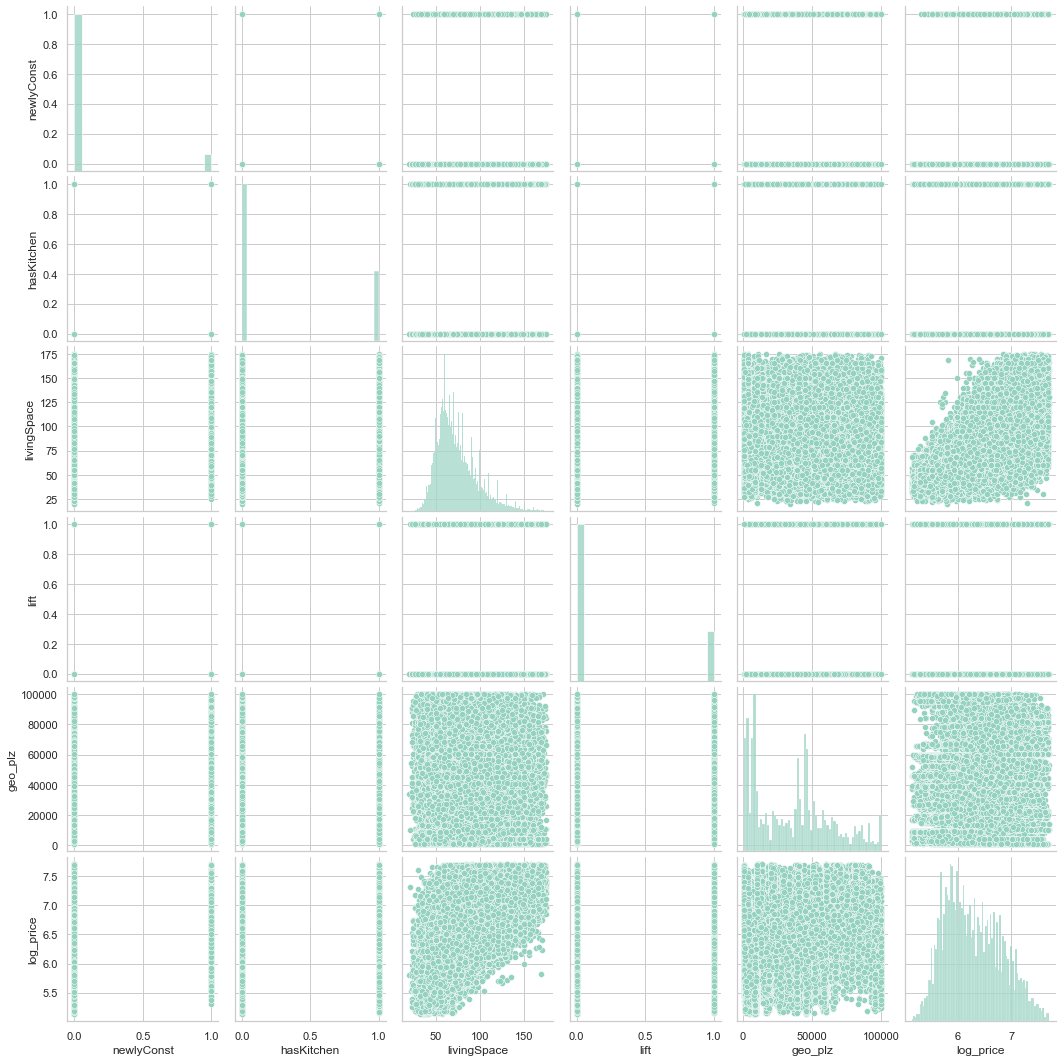

In [90]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.pairplot(data_final)

# 4. Modeling

## 4.1 Preparation of the modeling

Defining the target variables as "targets" and the predictors as "inputs"

In [91]:
targets = data_final["log_price"]
inputs = data_final.drop(["log_price"],axis=1)

### Scale the data
Scale the data set with scikit learn StandardScaler

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)

inputs_scaled = scaler.transform(inputs)

### Train Test Split

Devide the sample in a train and test set. Define a random sample of 20% as test data with the state 365

In [93]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

## 4.2 Create the regresion model

Define the regression with test data and fit the model.

In [94]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

### Applying the regression model to the training data

In [95]:
y_hat = reg.predict(x_train)

### Evaluation of the training data model
Comparison of the predictions with the actual values (targets)

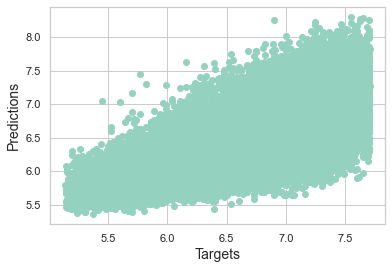

In [96]:
plt.scatter(y_train, y_hat)
plt.xlabel('Targets',size=14)
plt.ylabel('Predictions',size=14)
plt.show()

Probability Distribution Function of the deviation of the predicted values

/Users/Jumana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals PDF')

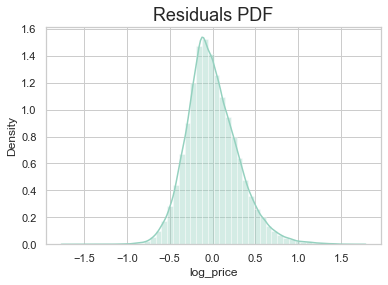

In [97]:
sns.distplot(y_train - y_hat)
plt.title("Residuals PDF", size=18)

R squared as a quality measure of the model

In [98]:
print('training performance:')
print(reg.score(x_train,y_train))

training performance:
0.674935582171114


In [99]:
print('reg intercept:')
print(reg.intercept_)

reg intercept:
6.29323730269735


Weighting of the predictors

In [100]:
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,newlyConst,0.084699
1,hasKitchen,0.114759
2,livingSpace,0.307220
3,lift,0.087225
4,geo_plz,0.104857


### Applying the regression model to the test data

In [101]:
y_hat_test = reg.predict(x_test)

## 4.3 Evaluation

R squared as a quality measure of the model

Assign a new indexing

In [102]:
y_test = y_test.reset_index(drop=True)
y_test.head()

0    6.577861
1    5.934894
2    6.696120
3    7.265430
4    5.646153
Name: log_price, dtype: float64

In [103]:
print('test performance')
print(reg.score(x_test,y_test))

test performance
0.6769948772700947


Mapping the predictions of the first 50 test data against the actual values (targets).

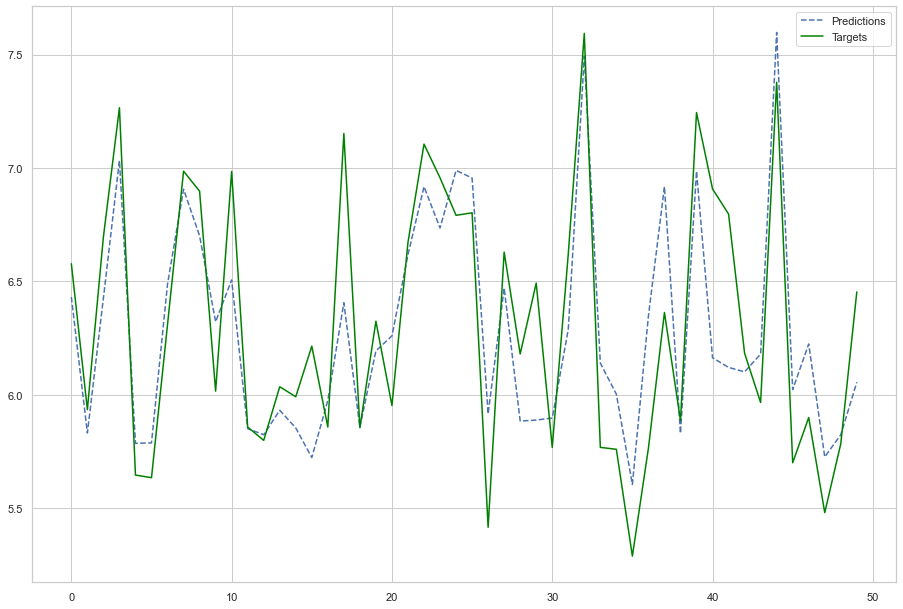

In [104]:
diag = plt.figure()

ax = diag.add_axes([0,0,2,2])

ax.plot(y_hat_test[:50], "b--")
ax.plot(y_test[:50], "green")
ax.legend(["Predictions","Targets"])

Comparison of the predictions with the actual values (targets)

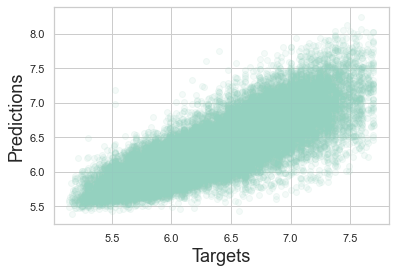

In [105]:
plt.scatter(y_test, y_hat_test, alpha=0.1)
plt.xlabel("Targets",size=18)
plt.ylabel("Predictions",size=18)
plt.show()

Show the predicted rental prices

In [106]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,621.075400
1,340.960659
2,617.850377
3,1133.747688
4,325.762741


Contrast the predicted values with the real values

In [107]:
df_pf['Target'] = np.exp(y_test)
df_pf.head()

,Prediction,Target
0,621.075400,719.00
1,340.960659,378.00
2,617.850377,809.26
3,1133.747688,1430.00
4,325.762741,283.20


Calculation of the absolute residuals

In [108]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf.head()

,Prediction,Target,Residual
0,621.075400,719.00,97.924600
1,340.960659,378.00,37.039341
2,617.850377,809.26,191.409623
3,1133.747688,1430.00,296.252312
4,325.762741,283.20,-42.562741


Calculation of the relative residuals

In [109]:
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf.head()

,Prediction,Target,Residual,Difference%
0,621.075400,719.00,97.924600,13.619555
1,340.960659,378.00,37.039341,9.798767
2,617.850377,809.26,191.409623,23.652426
3,1133.747688,1430.00,296.252312,20.716945
4,325.762741,283.20,-42.562741,15.029216


Descriptive statistics of predicted values, real values, their absolute residuals and ralative differences

In [110]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,33955.000000,33955.000000,33955.000000,33955.000000
mean,601.365238,627.011027,25.645789,23.629761
std,321.794265,370.254917,236.334701,19.533865
min,218.137127,171.000000,-1836.208033,0.000113
25%,386.495694,350.000000,-87.654706,9.147192
50%,497.164793,500.000000,-14.770987,19.292079
75%,708.334011,799.000000,105.920747,33.114130
max,3816.208033,2205.000000,1600.039097,428.115674


MAE, MSE and RMSE

In [111]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_hat_test))
print('MSE:', metrics.mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))

MAE: 0.2350186650540862
MSE: 0.09181514789246176
RMSE: 0.3030101448672334
